# Time Series Sampling

## Introduction

Open Data API (abbreviated to `odapi`) provides convenient interfaces such as the `TimeSerieAPI` interface to make time series management easier to the end user. 

Those interfaces are derived to create connectors such as the `Irceline` connector. As a first example, we will download a trial dataset from the [Irceline][1] [API][2] using the eponymous connector. Dataset created will be used in subequent notebooks to show time series capabilities of the package.

[1]: https://www.irceline.be/en
[2]: https://github.com/irceline/open_data

### Import package

All we need is to import the `Irceline` connector form the `odapi` package:

In [1]:
from odapi.connectors import Irceline

Additionally, we may silence logs as `odapi` package is bit verbose:

In [2]:
from odapi.settings import settings
settings.logger.setLevel(40)

### Create connector

Create a instance of `Irceline` connector to control the Irceline underlying API:

In [3]:
client = Irceline()

Now, we are ready to use the Open Data API.

## Create Dataset

Now we will create a typical Air Quality Dataset to feed subsequent examples. We will sample Air Quality Data of Brussels City (Central Europe) for the 2014 civil year.

### Metadata

All interfaces from `odapi` exposes metadata. We fetch the metadata from the Irceline API to se what it holds. Because we are dealing with air quality time series, metadata will looks like measurment channels. We sample 10 channels at random and show the 8 first columns:

In [4]:
meta = client.meta
meta.sample(10).iloc[:,:8]

,serieid,siteid,measureid,serieunits,measurekey,measurename,sitekey,sitename
313,10866,1713,6002,µg/m³,PM-1.0,Particulate Matter < 1 µm,42R805,Antwerpen (Belgiëlei)
495,10814,1713,62106,%,RH,relative humidity,42R805,Antwerpen (Belgiëlei)
229,7073,1207,38,µg/m³,NO,Nitrogen monoxide,44R701,Gent
364,6643,1124,5,µg/m³,PM-10.0,Particulate Matter < 10 µm,41WOL1,Wol.St.L.
129,6955,1183,8,µg/m³,NO2,Nitrogen dioxide,43N113,Sainte-Ode
173,10837,1736,38,µg/m³,NO,Nitrogen monoxide,RMBX03,Bruxelles (Brouckere)
46,6514,1112,10,mg/m³,CO,Carbon Monoxide,41B006,Bruxelles (Parlement UE)
276,6969,1185,7,µg/m³,O3,Ozone,43N132,Habay-La-Neuve
200,6775,1147,38,µg/m³,NO,Nitrogen monoxide,42R801,Borgerhout
168,10750,1722,38,µg/m³,NO,Nitrogen monoxide,47E704,Wachtebeke


The complete list of available metadata is:

In [5]:
meta.dtypes

serieid                     object
siteid                       int64
measureid                   object
serieunits                  object
measurekey                  object
measurename                 object
sitekey                     object
sitename                    object
seriekey                    object
lat                        float64
lon                        float64
start          datetime64[ns, UTC]
stop           datetime64[ns, UTC]
dtype: object

The main columns we are concerned about are:

In [6]:
keys = ['serieid', 'seriekey', 'measurekey', 'sitekey', 'measurename', 'sitename']

#### Selection 

From this, we can make a precise selection of measurement channels using the `select` method (`sitekey` starting by `41` are located in Brussels):

In [7]:
sel = client.select(sitekey='41....',
                    measurekey=['NO', 'O3', 'CO', 'SO2',
                                'PM-', 'BC', 'RH', 'T$', 'W'])[keys]
sel

,serieid,seriekey,measurekey,sitekey,measurename,sitename
14,10607,BC/41R012 (µg/m³),BC,41R012,Black Carbon,Uccle
17,10693,BC/41N043 (µg/m³),BC,41N043,Black Carbon,Haren
29,6569,BC/41R001 (µg/m³),BC,41R001,Black Carbon,Molenbeek-Saint-Jean
30,6609,BC/41R002 (µg/m³),BC,41R002,Black Carbon,Ixelles
31,6633,BC/41WOL1 (µg/m³),BC,41WOL1,Black Carbon,Wol.St.L.
...,...,...,...,...,...,...
575,99941,T/41R012 (°C),T,41R012,temperature,Uccle
581,99915,WD/41R001 (°G),WD,41R001,wind direction,Molenbeek-Saint-Jean
582,99939,WD/41R012 (°G),WD,41R012,wind direction,Uccle
587,99916,WS/41R001 (m/s),WS,41R001,wind speed (scalar),Molenbeek-Saint-Jean


A complete overview of the selection is (table shows serie identifiers):

In [8]:
sel.pivot_table(index='sitekey', columns='measurekey',
                values='serieid', aggfunc='first')\
   .style.format('{}', na_rep='-')

measurekey,BC,CO,CO2,NO,NO2,O3,PM-10.0,PM-2.5,RH,SO2,T,WD,WS
sitekey,,,,,,,,,,,,,
41B001,-,6500,-,6503,6504,-,-,-,-,6502,-,-,-
41B004,-,6506,-,6507,6508,6509,-,-,-,-,-,-,-
41B006,-,6514,-,6515,6516,6517,-,-,-,-,-,-,-
41B008,-,10616,-,10613,10614,-,-,-,-,10615,-,-,-
41B011,-,-,-,6527,6528,6530,6531,6532,-,-,99914,-,-
41MEU1,-,-,-,6550,6551,10766,6552,6553,-,6549,-,-,-
41N043,10693,6558,-,6560,6561,6562,6563,6564,-,6559,-,-,-
41R001,6569,6571,-,6573,6574,6577,6578,6579,10793,6572,99917,99915,99916
41R002,6609,6611,6612,6614,6615,-,-,-,-,6613,-,-,-


### Records

Using the selection done above, we can fetch records on a defined time range using the `get_records` method:

In [9]:
recs = client.get_records(sel, start='2014-01-01 00:00:00+0100',
                          stop='2015-01-01 00:00:00+0100')

We localize timestamps to the rightful timezone (`odapi` enforces Time Zone to be located in UTC internally):

In [10]:
recs['start'] = recs['start'].dt.tz_convert('CET')

We pivot records to align Time Series and ensure time axis is regular:

In [11]:
data = recs.merge(sel[keys])
data = data.pivot_table(index='start',
                        columns=['seriekey', 'sitekey', 'measurekey', 'serieid'],
                        values='value')
data = data.resample('1H').first()

A selection of final dataframe looks like:

In [12]:
data.filter(regex='NO.*/41R00(1|2)').tail()

seriekey,NO/41R001 (µg/m³),NO/41R002 (µg/m³),NO2/41R001 (µg/m³),NO2/41R002 (µg/m³)
sitekey,41R001,41R002,41R001,41R002
measurekey,NO,NO,NO2,NO2
serieid,6573,6614,6574,6615
start,,,,
2014-12-31 19:00:00+01:00,95.0,55.0,91.0,75.0
2014-12-31 20:00:00+01:00,52.0,52.0,73.0,69.5
2014-12-31 21:00:00+01:00,29.5,33.5,62.0,60.5
2014-12-31 22:00:00+01:00,32.5,34.5,60.5,57.5
2014-12-31 23:00:00+01:00,43.5,30.5,57.5,48.5


And finally, we draw some Time Series:

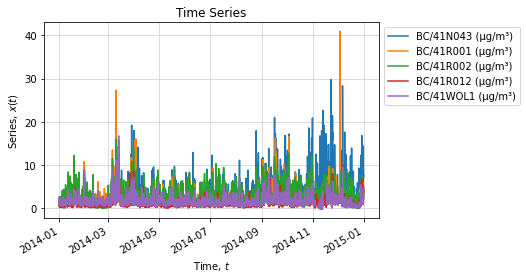

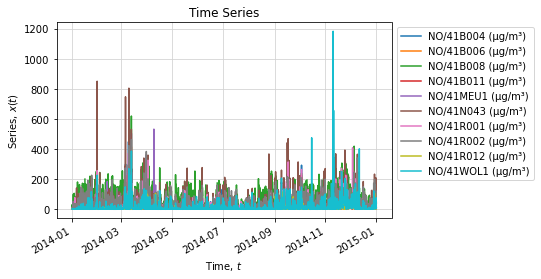

In [13]:
for k in ['BC', 'NO']:#data.columns.levels[2]:
    axe = data.filter(regex='{}/'.format(k)).droplevel([1,2,3], axis=1).plot()
    axe.set_title("Time Series")
    axe.set_xlabel("Time, $t$")
    axe.set_ylabel("Series, $x(t)$")
    lgd = axe.legend(bbox_to_anchor=(1, 1), loc='upper left')
    axe.grid(which='both', color='lightgray')

We store the final dataframe for subseqent examples (see next notebooks):

In [14]:
data.to_pickle("dump/brussels_2014.pickle")